# Reward Optimizing Recommendation using Deep Learning and Fast Maximum Inner Product Search (MIPS)


## Getting Started

In [ ]:
!pip install gdown
!git clone https://github.com/otmhi/Reward-Optimizing-Reco.git
%cd Reward-Optimizing-Reco

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'Reward-Optimizing-Reco'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 90 (delta 32), reused 22 (delta 7), pack-reused 0
Unpacking objects: 100% (90/90), done.
/content/Reward-Optimizing-Reco


In [ ]:
!gdown https://drive.google.com/u/0/uc?id=112Y_ggpjpk8M5zN7uxOYbLhZAm26qQJL&export=download
!unzip saved_models_and_indexes

Downloading...
From: https://drive.google.com/u/0/uc?id=112Y_ggpjpk8M5zN7uxOYbLhZAm26qQJL
To: /content/Reward-Optimizing-Reco/saved_models_and_indexes.zip
100% 458M/458M [00:03<00:00, 131MB/s]
Archive:  saved_models_and_indexes.zip
   creating: saved_models/Oracle/assets/
   creating: saved_models/PRRModel/assets/
replace saved_indexes/embedding_10000.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: saved_indexes/embedding_10000.npy  
   creating: saved_models/RewardModel/assets/
  inflating: saved_indexes/embedding_16900.npy  
  inflating: saved_models/PRRModel/saved_model.pb  
  inflating: saved_models/Oracle/saved_model.pb  
  inflating: saved_indexes/embedding_13000.npy  
  inflating: saved_indexes/embedding_62747.npy  
  inflating: saved_models/RewardModel/saved_model.pb  
  inflating: saved_indexes/embedding_28561.npy  
  inflating: saved_indexes/index_37129.index  
  inflating: saved_models/PRRModel/variables/variables.data-00000-of-00001  
  inflating: saved_models/PRR

In [ ]:
!apt install libomp-dev
!python -m pip install --upgrade faiss-cpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext rpy2.ipython

In [ ]:
import tensorflow as tf
import numpy as np
import faiss
import time
import matplotlib.pyplot as plt
import random 
import pickle

from models import PRRModel, RewardModel, SlateIPS, IndependentIPS, RandomModel
from utils.logging_policy import LoggingPolicy
from utils.simulator import Simulator
from utils.simulated_ab_test import ABTest

import pandas as pd

SEED=42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
class Oracle(PRRModel):
    def __init__(self, nb_gs_categories, nb_bidding_features, bidding_mean, max_slate_size, **kwargs):
        super().__init__(
            bidding_init=np.random.randn(nb_bidding_features,1) * .1 + bidding_mean,
            add_position_bias_init=np.random.randn(1, max_slate_size) * 1 + 0,
            mult_position_bias_init=1-np.arange(max_slate_size).reshape([1, -1])/40,
            nb_gs_categories=nb_gs_categories,
            nb_bidding_features=nb_bidding_features,
            bidding_mean=bidding_mean,
            max_slate_size=max_slate_size,
            **kwargs
        )
        self.context_lookup = tf.Variable(
            tf.eye(nb_gs_categories),
            trainable=False
        )
        self.product_lookup = tf.Variable(
            tf.constant([
                [-1, -1, -1, -1],
                [  1,-.4, -.6,  .8],
                [-.2,  1, 0.2,   0],
                [-.6,-.6,   0,   1],
                [ -1, .8, -.2, -.8],
                [  0,  0,   1,  .6],
                [-.8,-.2,  .8,  .4],
                [ .8, -1,  -1,  -1]
            ], dtype=tf.float32),
            trainable=False
        )

In [ ]:
config = dict(max_slate_size=4,
              min_slate_size=2,
              nb_bidding_features=2,
              bidding_mean=8.,
              embedding_dim=6,
              nb_gs_categories=4,
              max_gs_categories=1,
              greedy_coef=1, # 1 means all actions are random
              catalog_size=7,
              nb_samples=20_000,
              ab_test_samples=20_000,
              num_epochs=240,
              batch_size=1024,
              learning_rate=0.005)

In [ ]:
config['criterion'] = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
config['optimizer'] = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])

In [ ]:
PRETRAINED = True

In [ ]:
if PRETRAINED:
  oracle = tf.saved_model.load('saved_models/Oracle')

else:
  oracle = Oracle(**config)

  ## to save the oracle model
  #call = oracle.__call__.get_concrete_function(
              #tf.TensorSpec(None, tf.int32), 
              #tf.RaggedTensorSpec([None, None], dtype=tf.int32), 
              #tf.TensorSpec(None, tf.float32))
      
  #tf.saved_model.save(oracle, 'saved_models/Oracle', signatures=call)

logging_policy = RandomModel(**config)
simulator = Simulator(oracle_model=oracle, logging_model=logging_policy, **config)
logs = simulator(**config)

# getting the CTR of this generated log
ctr = np.mean([logs[i]['reward'] for i in range(len(logs))])
std = round(np.sqrt(ctr*(1-ctr)/config['nb_samples'])*100, 2)
ctr = round(ctr*100,2)
print(f"CTR Logs: {ctr} ± {std} %")

## to save the logs
#with open("saved_models/saved_logs", "wb") as fp:
#  pickle.dump(logs, fp)

## to load the logs
#with open("saved_logs", "rb") as fp:
#  b = pickle.load(fp)

  0%|          | 0/20000 [00:00<?, ?it/s]

/content/Reward-Optimizing-Reco/utils/simulator.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  single_item_propensity = tf.constant([logging_policy[action-1]], tf.float32)


CTR Logs: 5.96 ± 0.17 %


## Part2: Combining Reward and Rank (PRR) vs. Reward Only (Bandit)

In our slides, we introduced Probabilistic Rank and Reward model (PRR), a scalable probabilistic model for personalized slate recommendation. PRR can learn more effectively the probability of the recommended slate being successful by combining the reward - whether the slate was clicked - and the rank - the item on the slate that was clicked. In this part of the tutorial, we show that PRR learns more efficiently than bandit methods that use only the reward.

Recall that PRR assumes that the context $x=[y, z]$ is decomposed of two subvectors $y \in \mathbb{R}^{d_1},$ with $d_1>0$ and $z \in \mathbb{R}^{d_2},$ with $d_2>0$ such that $y$ are bidding features that are useful for predicting if an interaction with a slate will occur, independently of its items and $z$ contains remaining information in the context $x$. PRR also assumes the following parametric form on the reward and ranks given the recommended slate $a_1, \ldots ,a_K$ and the context $x$:
$$
\bar{c}, r_1, \ldots ,r_K | a_1, \ldots ,a_K, y, z  \sim {\rm cat}\left( \frac{\theta_0}{Z}, \frac{\theta_1}{Z}, \ldots, \frac{\theta_K}{Z} \right), \quad Z = \sum_{k=0}^K \theta_k,
$$
where ${\rm cat}$ is the categorical distribution, $\bar{c}$ is the regret, i.e., the indicator of no click on the slate: $\bar{c}=1$ when there is no click and 0 otherwise. Moreover, $r_1,...,r_K$ are the ranks of the $K$ items in the recommended slate (e.g., $r_k$ is equal to 1 if the user clicks on the item $a_k$ and 0 otherwise). Finally, the score $\theta_k$ for $k \in \{0, 1, \ldots, K\}$ are computed as follows:

The bidding features $y$ are used to produce a positive score $\theta_0$ which is high if the chance of no interaction is high, indepedently of the quality of recommendations $a_1, \ldots, a_K$:
$$
\theta_0 = \exp(y^\top \phi),
$$
where $\phi$ is a vector of learnable parameters of size $d_1>0$.

Similarly, the positive scores $\theta_k$ for $k=1, \dots, K$ associated with each of the $K$ items in the slate are calculated in a way that captures user interests, position biases, and interactions that occur by accident. Precisely, given a recommended slate $a_1, \dots, a_K$, the score $\theta_k$ has the form: 
$$    \theta_k = \exp \{ g_{\Gamma}(z)^\top \Psi_{a_k}\} \exp(\gamma_{k}) + \exp(\alpha_{k}).
$$

This formulation is motivated by practitioners experience.  The quantity $\exp(\alpha_k), k=1, \ldots, K$ denotes the additive bias for position $k$ in the slate. It is high if there is a high chance of interaction with the $k-$th item irrespective of how appealing it is to the user. This quantity also explains clicks that are not associated at all with the recommendation (e.g., clicks by accident). It follows that the probability of a click on slates is always larger than $\frac{\sum_{k=1}^{K} \exp(\alpha_k)}{Z}$. The quantity $\gamma_k, k=1, \ldots, K$ is the multiplicative bias, it is high if a good recommendation in position $k$ is `boosted' by being in position $k$.

The main quantity of interest for recommendation is the recommendation score which is $g_{\Gamma}(z)^\top \Psi_{a_k}$. This score can be understood as follows. The vector $z \in \mathbb{R}^{d_2}$ represents the user's interests and the vector $\Psi_{a_k} \in \mathbb{R}^{d_2}$ represents the embedding of the recommended item $a_k$. The vector $z$ is first mapped into an embeddings space of dimension $d_2$ using $g_{\Gamma}(\cdot)$. The resulting inner product $g_{\Gamma}(z)^\top \Psi{a_k}$ produces a positive or negative score that represents how good is $a_k$ (recommended item in position $k$) to the user. 

Now the reward only model (or bandit method) only uses the reward signal (click or no-click on the slate) and thus the corresponding model will have the form 
$$ \bar{c}, c | a_1,\ldots,a_K, y, z \sim {\rm cat}\left( \frac{\theta_0}{Z},  \frac{\sum_{k=1}^K\theta_k}{Z} \right), \quad Z = \sum_{k=0}^K \theta_k,
$$
where $c$ is the reward, i.e., the indicator of a click on the slate: $c=1$ when there is a click and 0 otherwise. 

In this part of the tutorial we compare the following two models:

$$ {\text{PRR Model: }} \bar{c}, r_1, \ldots ,r_K | a_1, \ldots ,a_K, y, z  \sim {\rm cat}\left( \frac{\theta_0}{Z}, \frac{\theta_1}{Z}, \ldots, \frac{\theta_K}{Z} \right), \quad Z = \sum_{k=0}^K \theta_k,
$$

$$ {\text{Reward Model: }} \bar{c}, c | a_1,\ldots,a_K, y, z \sim {\rm cat}\left( \frac{\theta_0}{Z},  \frac{\sum_{k=1}^K\theta_k}{Z} \right), \quad Z = \sum_{k=0}^K \theta_k.
$$

In [ ]:
# Training Reward and Rank (PRR), Rank only, and Reward Only

models = {'Oracle': oracle, 'Random': RandomModel(**config)}

if PRETRAINED:
  for Model in [RewardModel, PRRModel]:
    models[Model.__name__] = tf.saved_model.load('saved_models/' + Model.__name__)

else:
  for Model in [RewardModel, PRRModel]:
      config['optimizer'].learning_rate = config['learning_rate']
      model = Model(**config)
      print(f" Training {Model.__name__} ".center(40, "-"))
      model.train(logs, **config)
      models[Model.__name__] = model

      ## to save the models
      #call = models[Model.__name__].__call__.get_concrete_function(
              #tf.TensorSpec(None, tf.int32), 
              #tf.RaggedTensorSpec([None, None], dtype=tf.int32), 
              #tf.TensorSpec(None, tf.float32))
      
      #tf.saved_model.save(model, 'saved_models/' + Model.__name__, signatures=call)

In [ ]:
# compute \int P(c|a,Omega,X)P(X) dX - using PRR and Reward Models
def predictive_reward_oracle_model(models, logs, numX=600):

    inv_map_products = {0:'padding' , 1:'Run. Shoes', 2:'Phone', 3:'Boots', 4:'Mic', 5:'Carpet', 6:'Pillow', 7:'Tennis B.'}
    inv_map_context = {0: 'Sports', 1: 'Tech', 2: 'House', 3: 'Fashion'}

    vii = []
    vjj = []
    vscores = []
    vcontext = []
    vfull = []
    vrewardonly = []
    for ii in range(min(numX, len(logs))):
        sample = logs[ii]
        for cc in range(4): # for each context
            for ii in range(1,8): # for each pair of actions
                for jj in range(1,8):
                    if ii != jj:
                        scores = oracle(ind_products=tf.convert_to_tensor((np.array([[ii, jj]])),dtype=tf.int32),ind_segments=tf.RaggedTensor.from_tensor(tf.convert_to_tensor((np.array([[cc]])),dtype=tf.int32)), bidding_features=sample['bidding'])
                        vscores.append(1-np.exp(scores.numpy()[0,0])/np.sum(np.exp(scores.numpy())))

                        scores = models['PRRModel'](ind_products=tf.convert_to_tensor((np.array([[ii, jj]])),dtype=tf.int32),ind_segments=tf.RaggedTensor.from_tensor(tf.convert_to_tensor((np.array([[cc]])),dtype=tf.int32)), bidding_features=sample['bidding'])
                        vfull.append(1-np.exp(scores.numpy()[0,0])/np.sum(np.exp(scores.numpy())))

                        scores = models['RewardModel'](ind_products=tf.convert_to_tensor((np.array([[ii, jj]])),dtype=tf.int32),ind_segments=tf.RaggedTensor.from_tensor(tf.convert_to_tensor((np.array([[cc]])),dtype=tf.int32)), bidding_features=sample['bidding'])
                        vrewardonly.append(1-np.exp(scores.numpy()[0,0])/np.sum(np.exp(scores.numpy())))

                        vii.append('a1='+inv_map_products[ii])
                        vjj.append('a2='+inv_map_products[jj])

                        vcontext.append(inv_map_context[cc])
    df_a1_a2 = pd.DataFrame({'context': vcontext, 'a1': vii, 'a2': vjj, 'ctr': vscores, 'ctr_full': vfull, 'ctr_rew': vrewardonly}).sort_values(['context','ctr'],ascending=False) 
    return df_a1_a2

df_a1_a2 = predictive_reward_oracle_model(models, logs,numX=10)

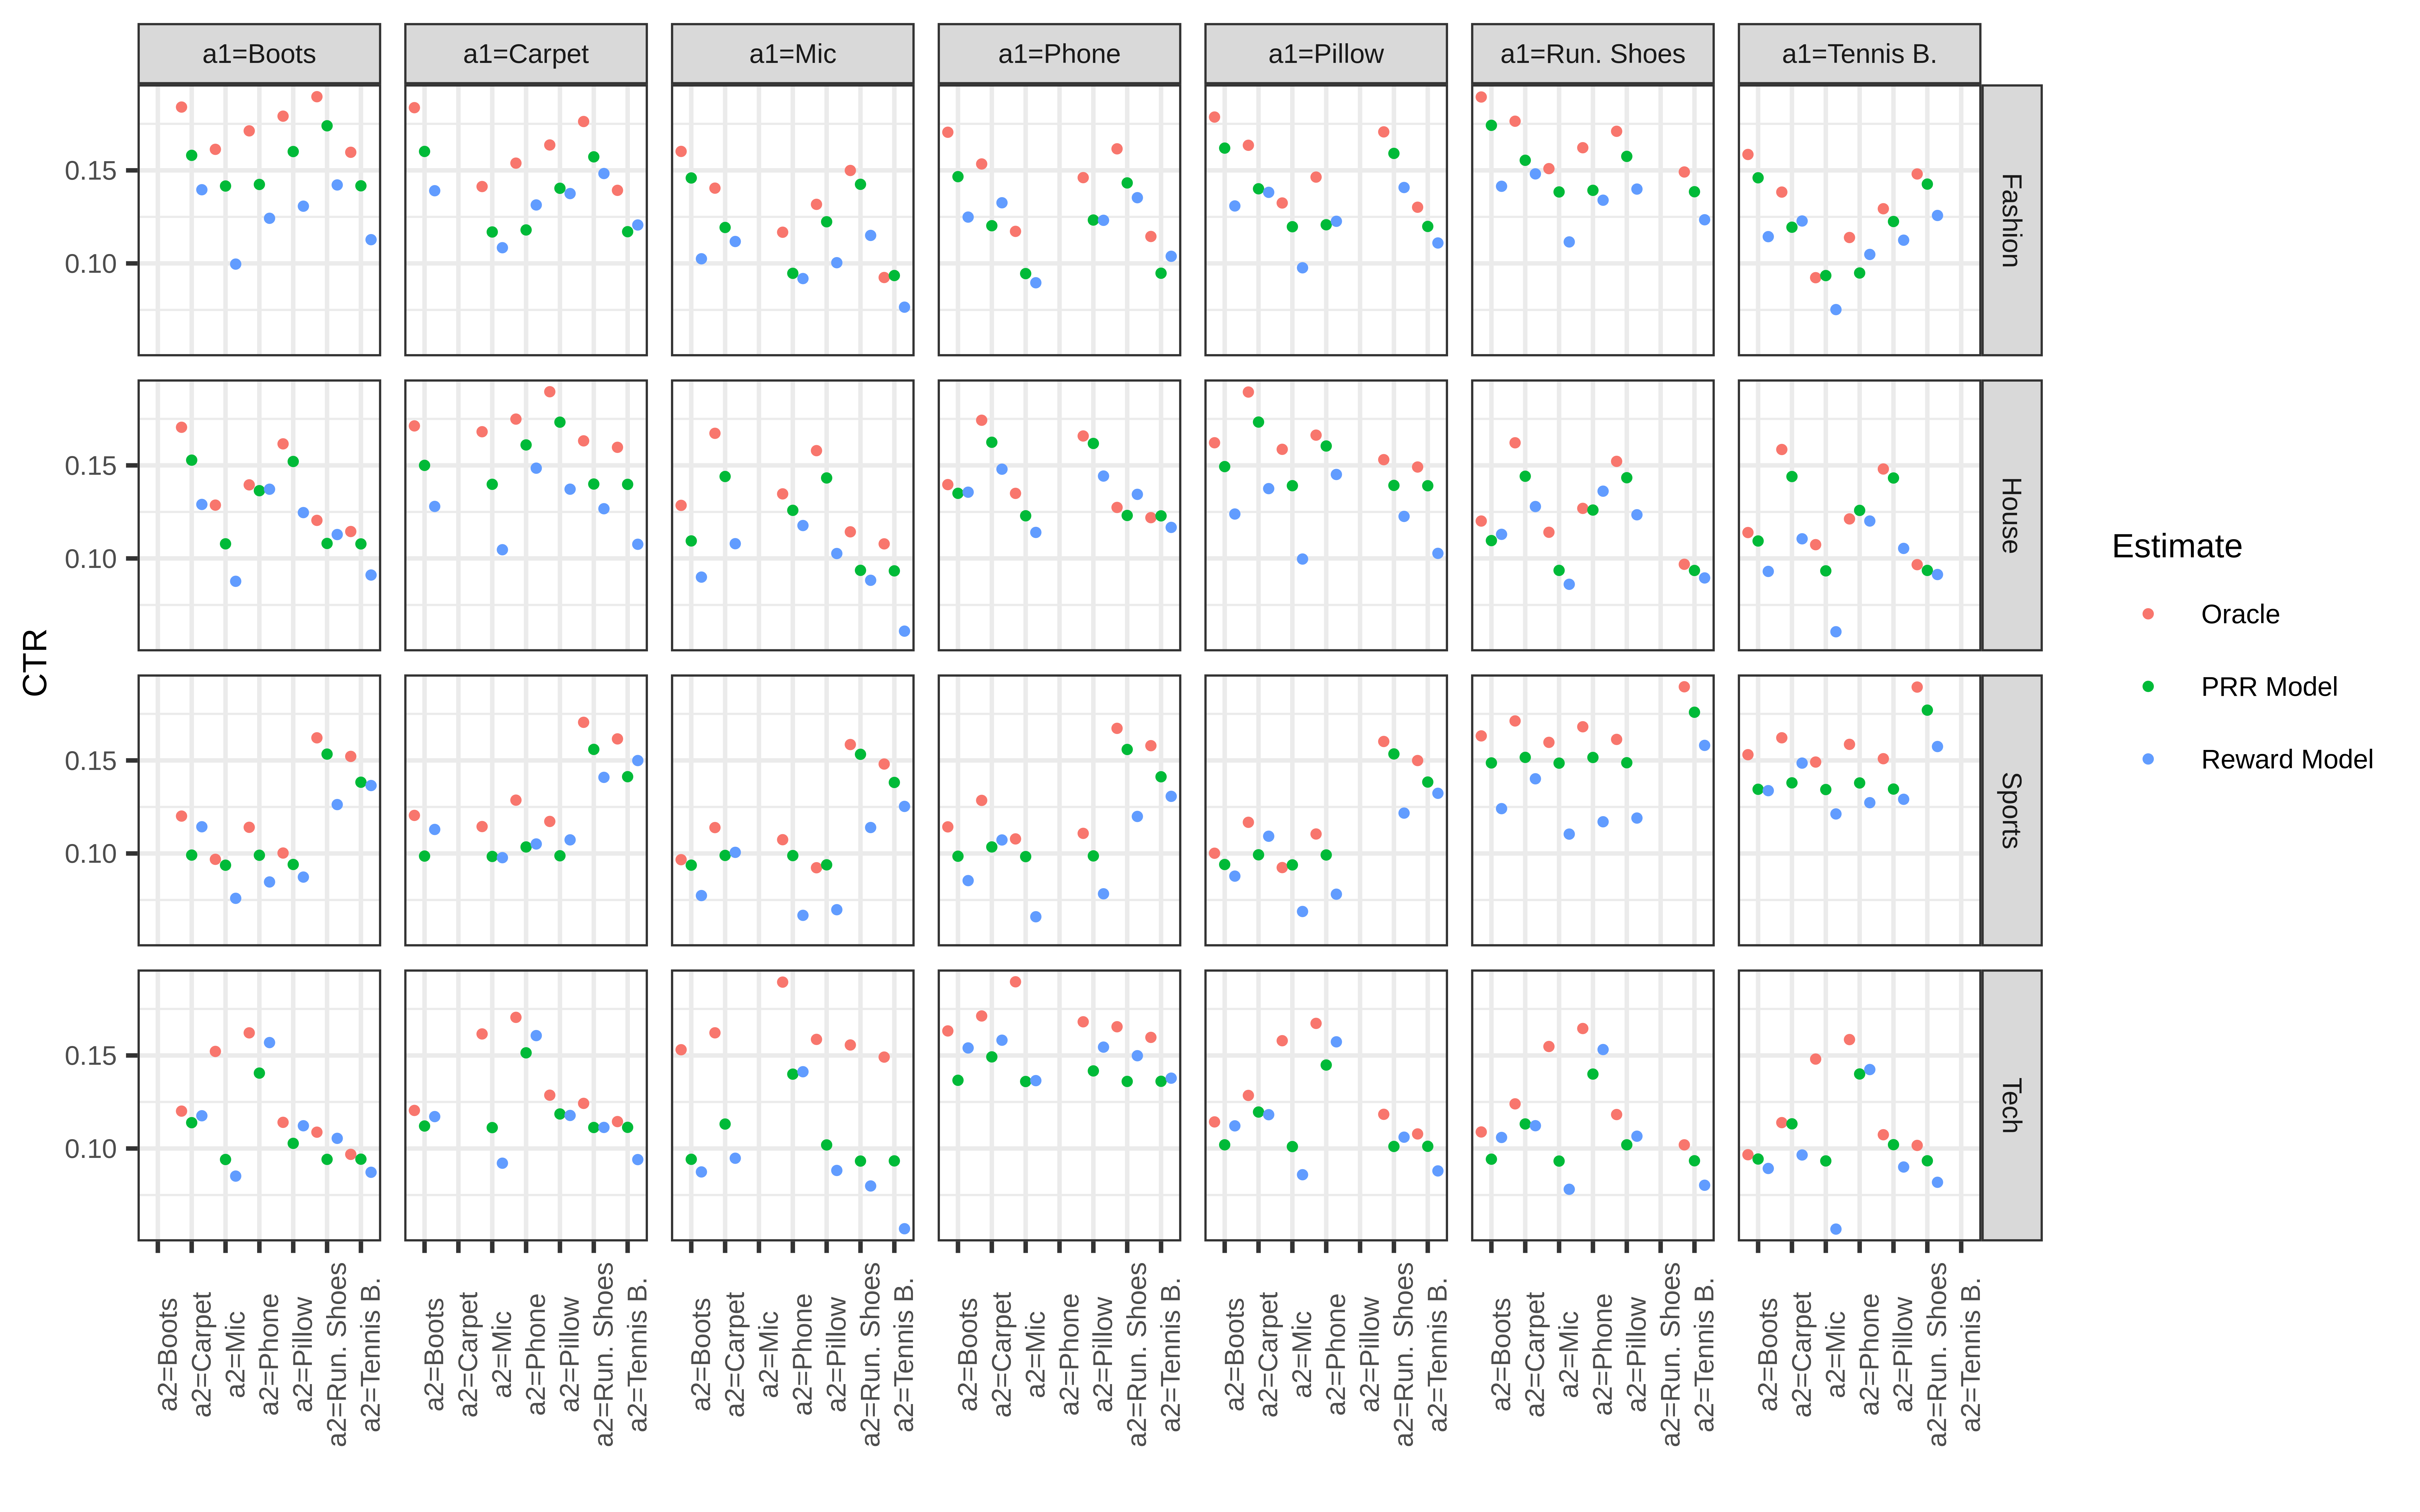

In [ ]:
%%R -i df_a1_a2 -w 8 -h 5 --units in -r 1000
library(data.table)
library(ggplot2)

# compute the oracle and PRR
df_a1_a2<-data.table(df_a1_a2)
g<-df_a1_a2[,list(ctr=mean(ctr),ctr.err=sd(ctr)/sqrt(.N),ctr_full=mean(ctr_full),ctr_rew=mean(ctr_rew)),list(context,a1,a2)]

# plot!
gg<-melt(g,c('context','a1','a2'),c('ctr','ctr_full','ctr_rew'))

setnames(gg,c('context','a1','a2','Estimate','value'))
gg[Estimate=='ctr',Estimate:='Oracle']
gg[Estimate=='ctr_full',Estimate:='PRR Model']
gg[Estimate=='ctr_rew',Estimate:='Reward Model']

ggplot(gg) + geom_point(aes(x=a2,y=value,colour=Estimate),size=0.6, position = position_dodge(width = 0.9)) + facet_grid(context ~ a1) + theme_bw() + theme(text = element_text(size = 8))   + theme(axis.text.x = element_text(angle = 90)) + ylab('CTR') + xlab('')  #+ coord_cartesian(xlim=c(0.15,0.4),ylim=c(0.15,0.4)) 

## Part3: Combining Reward and Rank vs. Inverse Propensity Score Methods

PRR is model-based method, and it is classified as a Direct Method (DM) as opposed to the commonly used inverse propensity score (IPS) methods. In this part of the tutorial, we show that PRR outperforms baselines such as slate IPS. While IPS makes very few assumptions, they are not able to exploit similarities between two slates $a_1,\ldots,a_K$ and $a_1',\ldots,a_K'$, even very basic similarities such as having common recommendations are ignored.

In [ ]:
# do IPS
def two_action_ips(logs):
    inv_map_products = {0:'padding' , 1:'Run. Shoes', 2:'Phone', 3:'Boots', 4:'Mic', 5:'Carpet', 6:'Pillow', 7:'Tennis B.'}
    inv_map_context = {0: 'Sports', 1: 'Tech', 2: 'House', 3: 'Fashion'}


    ll = []

    for ii in range(len(logs)):
        slate_size = logs[ii]['slate_size'].numpy()[0,0]
        if slate_size == 2:
            a1 = logs[ii]['products'].numpy()[0,0]
            a2 = logs[ii]['products'].numpy()[0,1]

            click = 1-logs[ii]['labels'].numpy()[0,0]

            ps = logs[ii]['slate_propensity'].numpy()[0]

            context = logs[ii]['gs'].numpy()[0,0]
            ll.append(pd.DataFrame({'context': [inv_map_context[context]], 'a1': 'a1='+inv_map_products[a1], 'a2': 'a2='+inv_map_products[a2], 'ps': ps, 'click': click}))

    df_ps = pd.concat(ll)
    return df_ps

df_ps = two_action_ips(logs)

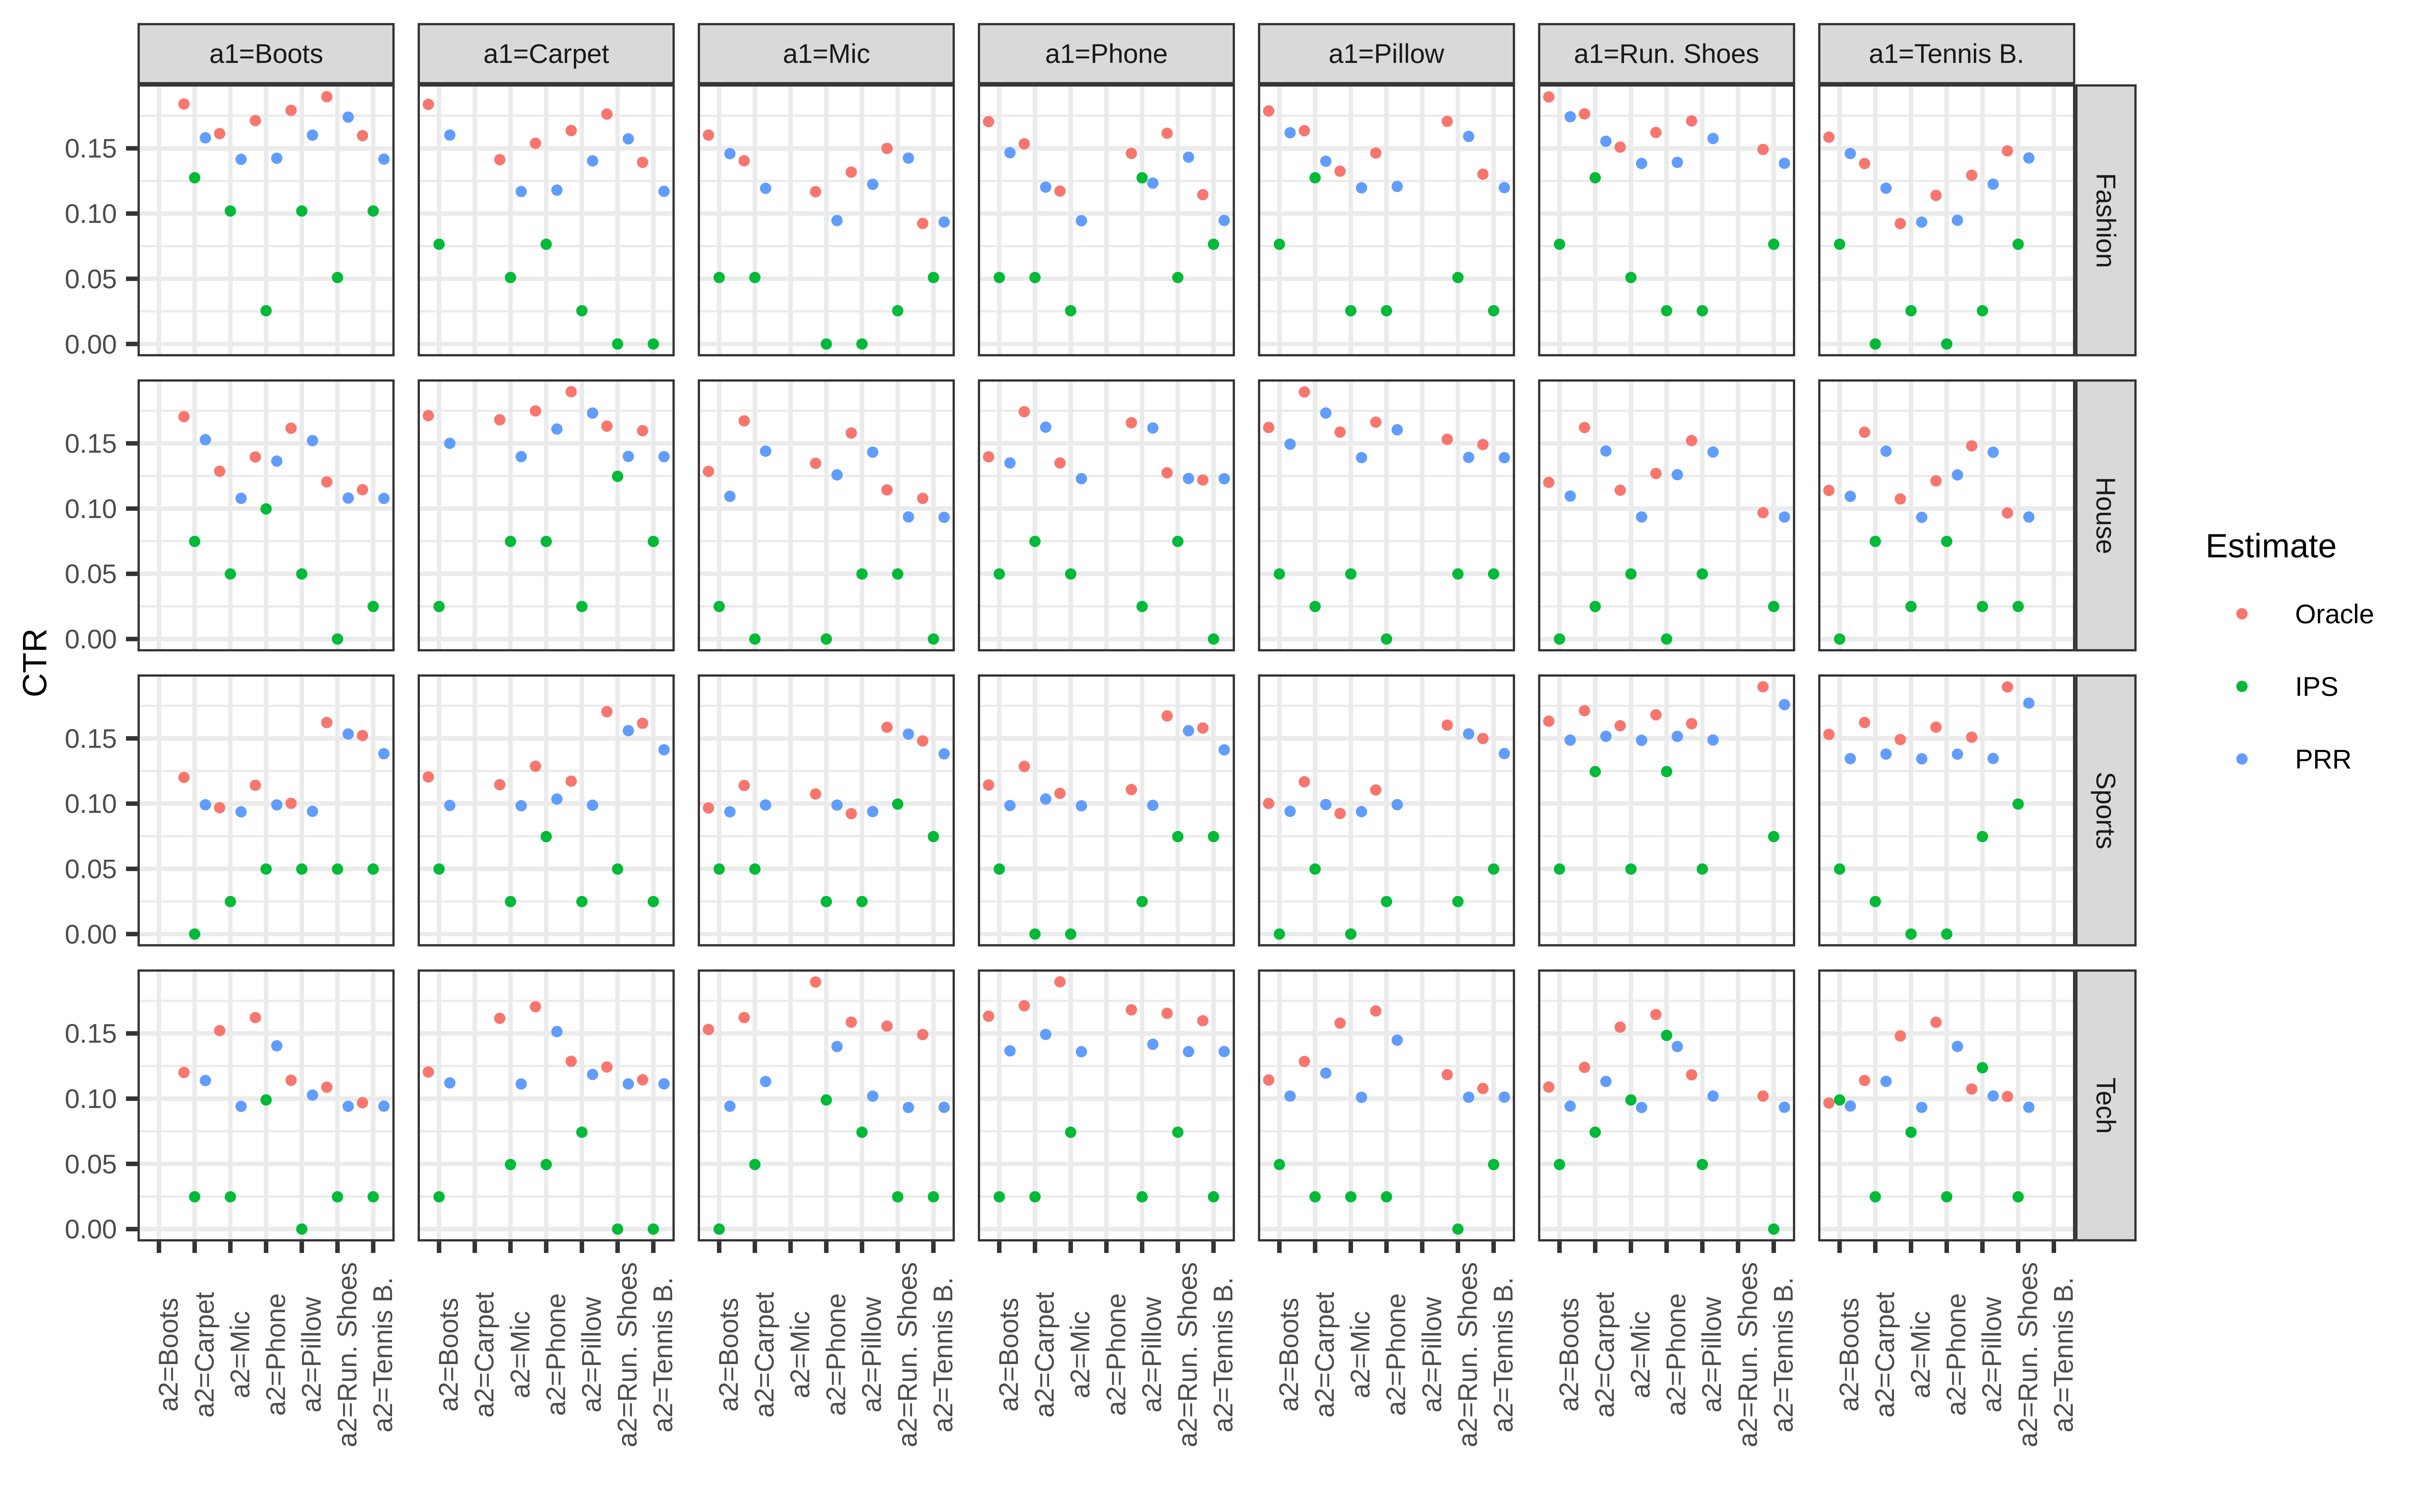

In [ ]:
%%R -i df_a1_a2 -i df_ps -w 8 -h 5 --units in -r 1000
library(data.table)
library(ggplot2)

# compute the orcale and model based estimates
df_a1_a2<-data.table(df_a1_a2)
g<-df_a1_a2[,list(ctr=mean(ctr),ctr.err=sd(ctr)/sqrt(.N),ctr_full=mean(ctr_full)),list(context,a1,a2)]


# compute the slate IPS based estimate
df_ps<-data.table(df_ps)
slateips<-merge(df_ps[,list(click=sum(click),ps=mean(ps)),list(a1, a2,context)],df_ps[,.N,context])
slateips<-slateips[,ctr_ips:=click/(ps*N)][,list(context,a1,a2,ctr_ips)]
g <-merge(g,slateips,by=c('context','a1','a2'))


# plot!
gg<-melt(g,c('context','a1','a2'),c('ctr','ctr_full','ctr_ips'))

setnames(gg,c('context','a1','a2','Estimate','value'))
gg[Estimate=='ctr',Estimate:='Oracle']
gg[Estimate=='ctr_ips',Estimate:='IPS']
gg[Estimate=='ctr_full',Estimate:='PRR']


ggplot(gg) + geom_point(aes(x=a2,y=value,colour=Estimate),size=0.6, position = position_dodge(width = 0.9)) + facet_grid(context ~ a1) + theme_bw() + theme(text = element_text(size = 8))   + theme(axis.text.x = element_text(angle = 90)) + ylab('CTR') + xlab('')


For additional details and experiments, we invite the curious reader to dive into the PRR model paper : [A Scalable Probabilistic Model for Reward Optimizing Slate
Recommendation](https://github.com/otmhi/Reward-Optimizing-Reco/blob/main/PRR_Slate_Recommendation.pdf)

# END